# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=70d3b670b2f863bed2968e226d7b1aa8dc167871bd3ecfc2d56e43c8b601abcb
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=3e195f03fdd8d70aad4f20487b0b2517e6032c7fe194b3292f079a1117e24d42
  Stored in directory: /root/.cache/pip/w

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 16.84 MiB/s, done.
Resolving deltas: 100% (3/3), done.


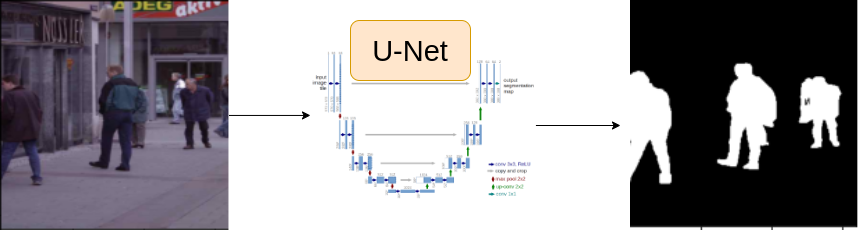

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_PATH = '/content/Human-Segmentation-Dataset-master/train.csv'
DIR = '/content/'
DEVICE = 'cuda'
Epochs = 25
lr = 0.0001
IMAGE_SIZE = 320

In [6]:
BATCH_SIZE = 16
ENCODER = 'timm-efficientnet-b0'
weights = 'imagenet'

In [7]:
df = pd.read_csv(CSV_PATH)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row = df.iloc[0]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)//255.0

print(image.shape, mask.shape)

(183, 276, 3) (183, 276)


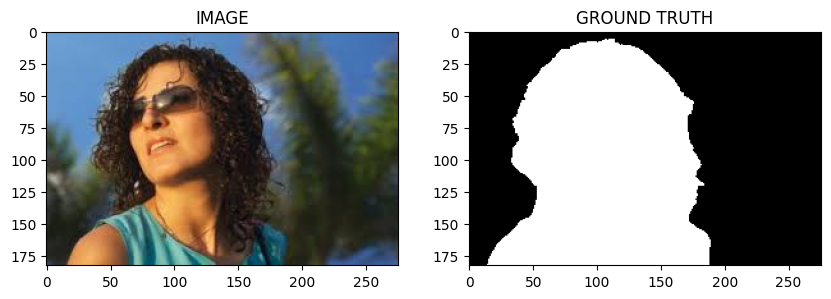

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask, cmap = 'gray')

In [10]:
train_df, valid_df = train_test_split(df, test_size = 0.2 , random_state=12)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE), 
      A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)
                    ], is_check_shapes=False)
  
def get_val_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)  
  ])


# Task 4 : Create Custom Dataset 

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
      return len(self.df)

  def __getitem__(self, idx):
      row = self.df.iloc[idx]
      image_path = row.images
      mask_path = row.masks
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      mask = np.expand_dims(mask, axis = -1)
      if self.augmentations:
        data = self.augmentations(image= image, mask = mask)
        image = data['image']
        mask = data['mask']

      image = np.transpose(image, (2,0,1)).astype(np.float32)  
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.tensor(image) / 255.0
      mask = torch.round(torch.tensor(mask) / 255.0)

      return image,mask


In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_val_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


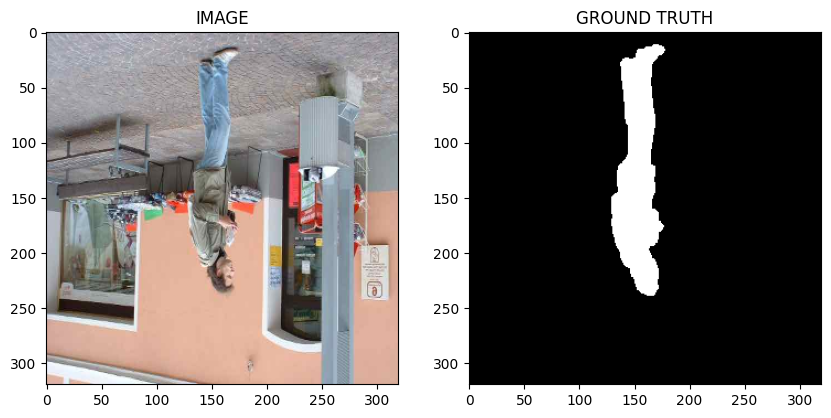

In [17]:
idx = 0
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size = 16, shuffle= True)
validloader = DataLoader(validset, batch_size = 16)

In [20]:
len(trainloader), len(validloader)

(15, 4)

In [21]:
for image, mask in trainloader:
  break

print(image.shape, mask.shape)

torch.Size([16, 3, 320, 320]) torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
from torch import nn
import segmentation_models_pytorch as smo
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc = smo.Unet(
        encoder_name=ENCODER,
        encoder_weights=weights,
        in_channels=3,
        classes = 1,
        activation=None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks!=None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss(logits,masks)

      return logits, loss1+loss2

    if masks == None:
      return logits



In [24]:
model = SegmentationModel()
model.to('cuda')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 26.5MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function 

In [25]:
def train_fn(train_loader, model, optimizer):
  model.train()
  train_loss = 0

  for images, masks in train_loader:
    images = images.to('cuda')
    masks = masks.to('cuda')
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  return train_loss/(len(train_loader))  



In [26]:
def val_fn(val_loader, model):
  model.eval()
  val_loss = 0
  with torch.zero_grad():
    for images, masks in val_loader:
      images = images.to('cuda')
      masks = masks.to('cuda')

      logits, loss = model(images, masks)
      vak_loss += loss

    return val_loss/(len(val_loader))  

# Task 8 : Train Model

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)

In [28]:
best_val_loss = np.Inf

for i in range(Epochs):
  train_loss = train_fn(train_loader=trainloader, model = model, optimizer= optimizer)
  val_loss = val_fn(val_loader=validloader, model = model)

  if val_loss < best_val_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_val_loss = val_loss

  print(i, train_loss, val_loss)


RuntimeError: ignored

# Task 9 : Inference